### R实现C5.0——C50

通过[库C50](https://www.rulequest.com/see5-info.html) 实现决策树算法C5.0.以下主要参考[C5.0 Classification Models](https://cran.r-project.org/web/packages/C50/vignettes/C5.0.html) 

#### Classification Trees

In [3]:
library(recipes)
data(credit_data)
# 查看数据
vars <- c("Home", "Seniority")
str(credit_data[, c(vars, "Status")])

'data.frame':	4454 obs. of  3 variables:
 $ Home     : Factor w/ 6 levels "ignore","other",..: 6 6 3 6 6 3 3 4 3 4 ...
 $ Seniority: int  9 17 10 0 0 1 29 9 0 0 ...
 $ Status   : Factor w/ 2 levels "bad","good": 2 2 1 2 2 2 2 2 2 1 ...


In [4]:
# a simple split
set.seed(2411)
in_train <- sample(1:nrow(credit_data), size = 3000)
train_data <- credit_data[ in_train,]
test_data  <- credit_data[-in_train,]

In [5]:
library(C50)
tree_mod <- C5.0(x = train_data[, vars], y = train_data$Status)
tree_mod


Call:
C5.0.default(x = train_data[, vars], y = train_data$Status)

Classification Tree
Number of samples: 3000 
Number of predictors: 2 

Tree size: 3 

Non-standard options: attempt to group attributes


In [6]:
summary(tree_mod)


Call:
C5.0.default(x = train_data[, vars], y = train_data$Status)


C5.0 [Release 2.07 GPL Edition]  	Fri Apr  5 22:01:52 2019
-------------------------------

Class specified by attribute `outcome'

Read 3000 cases (3 attributes) from undefined.data

Decision tree:

Seniority > 2: good (1971/396)
Seniority <= 2:
:...Home in {ignore,other,priv,rent}: bad (411.4/171)
    Home in {owner,parents}: good (617.6/226.6)


Evaluation on training data (3000 cases):

	    Decision Tree   
	  ----------------  
	  Size      Errors  

	     3  794(26.5%)   <<


	   (a)   (b)    <-classified as
	  ----  ----
	   240   623    (a): class bad
	   171  1966    (b): class good


	Attribute usage:

	100.00%	Seniority
	 34.27%	Home


Time: 0.0 secs


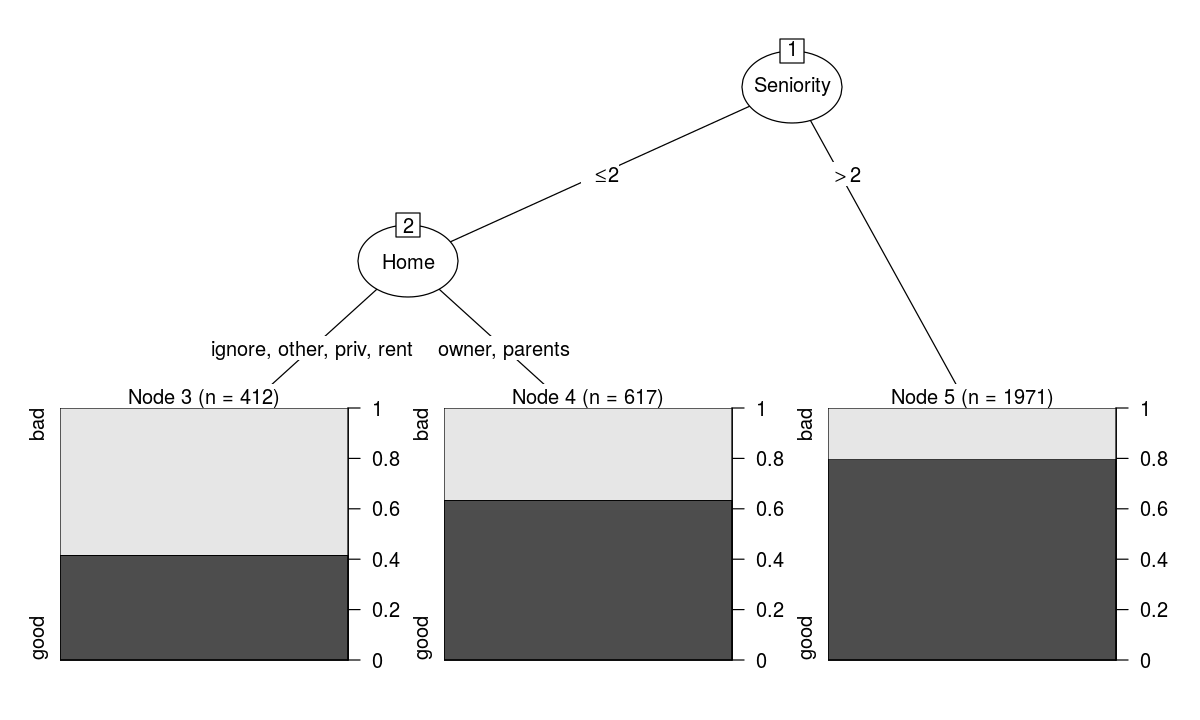

In [10]:
options(repr.plot.width=10, repr.plot.height=6)  # plot size
plot(tree_mod)

Another option that can be used is the trials argument which enables a boosting procedure. This method is model similar to AdaBoost than to more statistical approaches such as stochastic gradient boosting.

In [19]:
tree_boost <- C5.0(x = train_data[, vars], y = train_data$Status, trials = 3)
summary(tree_boost)


Call:
C5.0.default(x = train_data[, vars], y = train_data$Status, trials = 3)


C5.0 [Release 2.07 GPL Edition]  	Fri Apr  5 22:05:26 2019
-------------------------------

Class specified by attribute `outcome'

Read 3000 cases (3 attributes) from undefined.data

-----  Trial 0:  -----

Decision tree:

Seniority > 2: good (1971/396)
Seniority <= 2:
:...Home in {ignore,other,priv,rent}: bad (411.4/171)
    Home in {owner,parents}: good (617.6/226.6)

-----  Trial 1:  -----

Decision tree:

Seniority > 5: good (1331.5/339.5)
Seniority <= 5:
:...Seniority <= 0: bad (392.4/173)
    Seniority > 0: good (1276.1/542.7)

-----  Trial 2:  -----

Decision tree:
 good (2426/564.2)


Evaluation on training data (3000 cases):

Trial	    Decision Tree   
-----	  ----------------  
	  Size      Errors  

   0	     3  794(26.5%)
   1	     3  843(28.1%)
   2	     1  863(28.8%)
boost	        803(26.8%)   <<


	   (a)   (b)    <-classified as
	  ----  ----
	   103   760    (a): class bad
	    43  2094  

#### Rule-Based Models

There is no plot method for rule-based models.

In [21]:
rule_mod <- C5.0(x = train_data[, vars], y = train_data$Status, rules = TRUE)
rule_mod


Call:
C5.0.default(x = train_data[, vars], y = train_data$Status, rules = TRUE)

Rule-Based Model
Number of samples: 3000 
Number of predictors: 2 

Number of Rules: 3 

Non-standard options: attempt to group attributes


In [22]:
summary(rule_mod)


Call:
C5.0.default(x = train_data[, vars], y = train_data$Status, rules = TRUE)


C5.0 [Release 2.07 GPL Edition]  	Fri Apr  5 22:06:15 2019
-------------------------------

Class specified by attribute `outcome'

Read 3000 cases (3 attributes) from undefined.data

Rules:

Rule 1: (411/171, lift 2.0)
	Home in {ignore, other, priv, rent}
	Seniority <= 2
	->  class bad  [0.584]

Rule 2: (1971/396, lift 1.1)
	Seniority > 2
	->  class good  [0.799]

Rule 3: (1940/423, lift 1.1)
	Home in {owner, parents}
	->  class good  [0.782]

Default class: good


Evaluation on training data (3000 cases):

	        Rules     
	  ----------------
	    No      Errors

	     3  794(26.5%)   <<


	   (a)   (b)    <-classified as
	  ----  ----
	   240   623    (a): class bad
	   171  1966    (b): class good


	Attribute usage:

	 79.40%	Seniority
	 78.37%	Home


Time: 0.0 secs


#### Predictions

In [23]:
predict(rule_mod, newdata = test_data[1:3, vars])

[1] good bad  good
Levels: bad good

In [24]:
predict(tree_boost, newdata = test_data[1:3, vars], type = "prob")

,bad,good
3,0.0000000,1.0000000
4,0.5981465,0.4018535
7,0.0000000,1.0000000


#### Cost-Sensitive Models
对不同的错误类型（如F->T，T->F）,定义不同的惩罚，组成Cost Matrix

In [25]:
cost_mat <- matrix(c(0, 2, 1, 0), nrow = 2)
rownames(cost_mat) <- colnames(cost_mat) <- c("bad", "good")
cost_mat

,bad,good
bad,0,1
good,2,0


In [26]:
cost_mod <- C5.0(x = train_data[, vars], y = train_data$Status, 
                 costs = cost_mat)
summary(cost_mod)


Call:
C5.0.default(x = train_data[, vars], y = train_data$Status, costs = cost_mat)


C5.0 [Release 2.07 GPL Edition]  	Fri Apr  5 22:10:07 2019
-------------------------------

Class specified by attribute `outcome'

Read 3000 cases (3 attributes) from undefined.data
Read misclassification costs from undefined.costs

Decision tree:

Seniority <= 2: bad (1029/562)
Seniority > 2:
:...Home in {ignore,owner,parents}: good (1331.7/199.4)
    Home in {other,priv,rent}:
    :...Seniority > 15: good (130/21)
        Seniority <= 15:
        :...Seniority <= 5: bad (199.6/116.3)
            Seniority > 5: good (309.6/92.3)


Evaluation on training data (3000 cases):

	       Decision Tree       
	  -----------------------  
	  Size      Errors   Cost  

	     5  991(33.0%)   0.43   <<


	   (a)   (b)    <-classified as
	  ----  ----
	   550   313    (a): class bad
	   678  1459    (b): class good


	Attribute usage:

	100.00%	Seniority
	 65.57%	Home


Time: 0.0 secs


In [27]:
# more samples predicted as "bad"
table(predict(cost_mod, test_data[, vars]))


 bad good 
 569  885 

In [28]:
# that previously
table(predict(tree_mod, test_data[, vars]))


 bad good 
 190 1264 

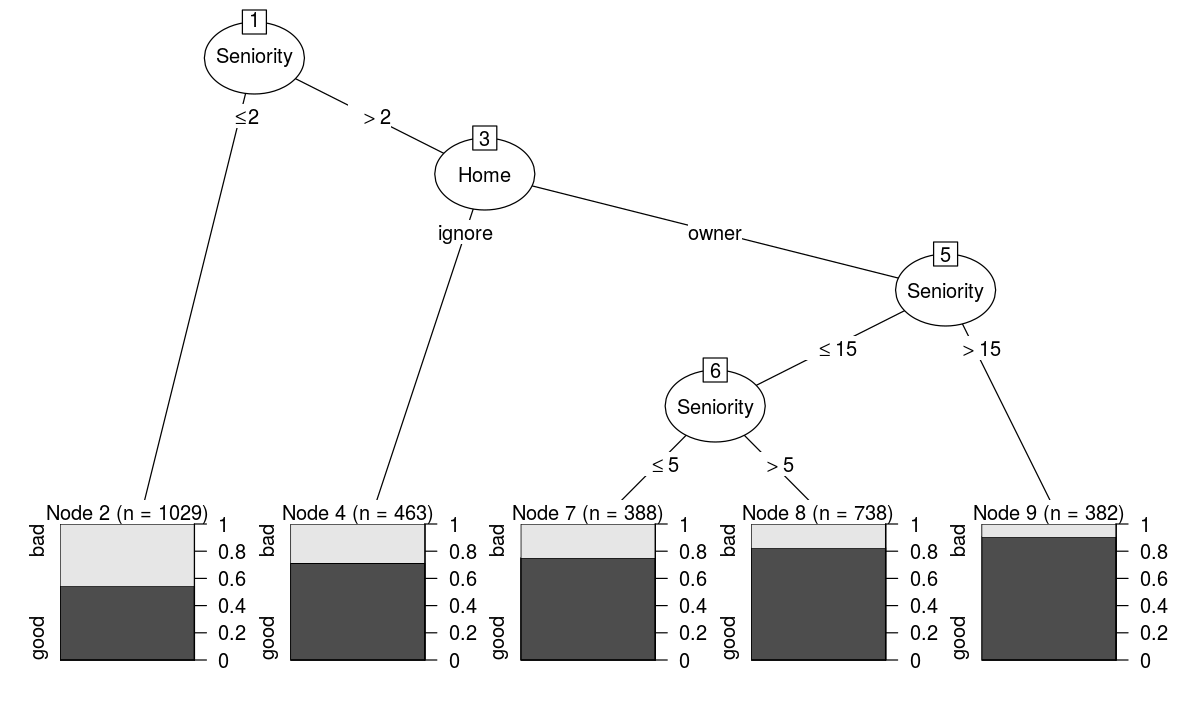

In [29]:
plot(cost_mod)